In [1]:
from utils_tools.utils_extension_vis_2d import estimate_true_error_local_max, plot_2D_comparison_with_coverage_error_compare, visualize_selected_points, plot_metrics_table

In [2]:

import torch
from typing import Sequence, Literal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def add_gaussian_noise_xy(  # name kept for drop-in; now soft-step by default
    xy: torch.Tensor,                 # (N, 2)
    u: torch.Tensor,                  # (N, 1) or (N,)
    *,
    centers: Sequence[Sequence[float]],
    radii: float | Sequence[float] | Sequence[Sequence[float]],
    sigmas: float | Sequence[float],
    base_sigma: float = 0.0,          # background noise std
    index_eps: float = 1e-6,          # threshold above background to count as "modified"
    generator: torch.Generator | None = None,
    clamp: tuple[float, float] | None = None,
    return_sigma: bool = False,
    combine: Literal["sum", "max", "quadrature"] = "sum",
    edge_tau: float = 0.05,           # NEW: softness of the boundary (in normalized radial units)
):
    """
    Adds heteroscedastic noise with *soft-step* 'islands':
      For each center c_k with radius r_k (or ellipse (rx, ry)),
      points get extra noise S_k weighted by a smooth indicator:

          w_k(x) = sigmoid( (1 - d_k(x)) / edge_tau ),
          d_k(x) = sqrt( ((x - c_k)/r_k)^T ((x - c_k)/r_k) )  (normalized distance)

      So w_k ≈ 1 deep inside (d<<1), w_k ≈ 0.5 at the boundary (d=1),
      and w_k → 0 smoothly outside.

    Aggregation across overlapping regions is controlled by `combine`:
      - "sum"        : sigma = base_sigma + sum_k S_k * w_k
      - "max"        : sigma = base_sigma + max_k (S_k * w_k)
      - "quadrature" : sigma = sqrt(base_sigma^2 + sum_k (S_k^2 * w_k^2))

    Returns:
        (u_noisy, idx)                 OR
        (u_noisy, sigma, idx)          if return_sigma=True
      - u_noisy: (N, 1)
      - sigma:   (N, 1) (only if return_sigma=True)
      - idx:     1D LongTensor where (sigma - base_sigma) > index_eps

    Notes:
      - `edge_tau` is in normalized radial units (relative to each island’s radius).
        As a rough rule, the 10–90% transition width in d is ≈ 4.394 * edge_tau.
        Set edge_tau→small (e.g., 0.01) to approach a hard step.
    """
    # --- shape checks / normalize ---
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError("xy must have shape (N, 2)")
    u = u.reshape(-1, 1)
    if xy.shape[0] != u.shape[0]:
        raise ValueError("xy and u must have the same number of points (N)")

    device, dtype = u.device, u.dtype
    XY = xy.to(device=device, dtype=dtype)

    # --- centers ---
    C = torch.as_tensor(centers, dtype=dtype, device=device).reshape(-1, 2)  # (K,2)
    K = C.shape[0]

    # Fast path: no centers -> background only
    if K == 0:
        sigma = torch.full_like(u, float(base_sigma))
        noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
        u_noisy = u + noise
        if clamp is not None:
            lo, hi = clamp
            u_noisy = u_noisy.clamp(min=lo, max=hi)
        idx = torch.zeros(0, dtype=torch.long, device=device)
        return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)

    # --- per-center amplitudes (S) ---
    S = (torch.full((K,), float(sigmas), dtype=dtype, device=device)
         if isinstance(sigmas, (int, float))
         else torch.as_tensor(sigmas, dtype=dtype, device=device).reshape(-1))
    if S.numel() != K:
        raise ValueError("sigmas must be scalar or length == len(centers)")

    # --- radii: scalar, (K,), or (K,2) for anisotropic (rx, ry) ---
    R_raw = torch.as_tensor(radii, dtype=dtype, device=device)
    if R_raw.ndim == 0:
        R_iso = R_raw.expand(K)    # isotropic radius shared by all
        R_aniso = None
    elif R_raw.ndim == 1:
        if R_raw.numel() != K:
            raise ValueError("radii 1D must have length == len(centers)")
        R_iso = R_raw
        R_aniso = None
    elif R_raw.ndim == 2 and R_raw.shape == (K, 2):
        R_iso = None
        R_aniso = R_raw
    else:
        raise ValueError("radii must be scalar, length-K, or shape (K,2) for anisotropic")

        # --- compute normalized squared distance Q and soft weights w ---
    diff = XY[:, None, :] - C[None, :, :]          # (N,K,2)
    tiny = torch.finfo(dtype).tiny
    if R_aniso is None:
        R2 = (R_iso.clamp_min(tiny)) ** 2          # (K,)
        Q  = (diff.pow(2).sum(dim=2)) / R2[None, :]   # (N,K)
    else:
        R2 = (R_aniso.clamp_min(tiny)) ** 2        # (K,2)
        Q  = (diff.pow(2) / R2[None, :, :]).sum(dim=2)  # (N,K)

    d = Q.clamp_min(0).sqrt()
    tau = max(float(edge_tau), 1e-12)
    w = torch.sigmoid((1.0 - d) / tau).to(dtype)   # (N,K) in (0,1)

    # --- aggregate sigma by chosen rule ---
    if combine == "sum":
        add = w * S[None, :]
        sigma = add.sum(dim=1, keepdim=True) + float(base_sigma)
    elif combine == "max":
        add = w * S[None, :]
        sigma = add.max(dim=1, keepdim=True).values + float(base_sigma)
    elif combine == "quadrature":
        add = (w * S[None, :]) ** 2
        sigma = (add.sum(dim=1, keepdim=True) + float(base_sigma) ** 2).sqrt()
    else:
        raise ValueError("combine must be one of: 'sum', 'max', 'quadrature'")

    sigma = sigma.clamp_min(0)

    # === NEW: indices strictly inside at least one island (hard mask) ===
    # Use Q < 1 (strictly inside). Add a tiny tolerance to avoid boundary picks.
    inside = (Q < (1.0 + 2)).any(dim=1)        # (N,)
    idx = torch.nonzero(inside, as_tuple=False).squeeze(1)

    # --- sample noise & add ---
    noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
    u_noisy = u + noise
    if clamp is not None:
        lo, hi = clamp
        u_noisy = u_noisy.clamp(min=lo, max=hi)

    return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)


In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
# torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D
from utils_tools.utils_tuning import save_plot

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
seed = 259 # HAPPY BIRTHDAY :)
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 1024  # Number of collocation points

data_noise = 0.05
N_train = 300
N_test = 2000 # 2000
N_calib = 100



N_total= N_train+N_test+N_calib

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)



# Not involved in numerical experiment
N_valid = 200
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)
X_vis, Y_vis = pde.data_generation(N_total, data_noise)

# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(n=20, step=0.05)

alpha = 0.05

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()



# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 500)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 500
g  = torch.Generator().manual_seed(seed)

# Define printing grid
grid_test, u = pde.solution_field_on_grid(n_grid, source="true", flatten=True)
u_noisy, sigma, id_grid = add_gaussian_noise_xy(
    grid_test, u,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.4,],
    base_sigma=0.05,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)

Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()

Y_train, sigma_train, id_train = add_gaussian_noise_xy(
    X_train, Y_train_clean,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.4,],
    base_sigma=0.0,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)
Y_test, sigma_test, id_test = add_gaussian_noise_xy(
    X_test, Y_test_clean,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.4,],
    base_sigma=0.0,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)
Y_calibration, sigma_calibration, id_calibration = add_gaussian_noise_xy(
    X_calibration, Y_cal_clean,
    centers=[(0.0,0.0)],
    radii=[0.2,],
    sigmas=[0.4,],
    base_sigma=0.0,
    combine="sum",
    generator=g,
    return_sigma=True,
    edge_tau=0.2
)


save_plot(
    plot_truth_and_samples_2D,
    save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
)(
    X_test, Y_test, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


<Figure size 640x480 with 0 Axes>

# Training

In [4]:
import matplotlib.colors as mcolors
# Define color map
colors = ["#2989ff","#ffffff", "#ff424f"]
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

colors = ["#8c52ff","#ffffff", "#ff66c4"]
my_cmap_2 = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)


# Feature Distance model

In [5]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}
raw_heuristic = "feature"
# CP-Model
k=30 # 30
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":raw_heuristic,
    "n_samples":k
}

dist_feat_pinn = DistanceUQPINN(**model_args)

In [6]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=4500,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=k,
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=4.78e+01 | lr=1.0e-03
ep   500 | L=2.92e-02 | lr=1.0e-03
ep  1000 | L=1.29e-02 | lr=1.0e-03
ep  1500 | L=9.38e-03 | lr=1.0e-03
ep  2000 | L=7.98e-03 | lr=1.0e-03
ep  2500 | L=7.23e-03 | lr=1.0e-03
ep  3000 | L=6.80e-03 | lr=1.0e-03
ep  3500 | L=6.56e-03 | lr=1.0e-03
ep  4000 | L=6.37e-03 | lr=1.0e-03
ep  4500 | L=6.27e-03 | lr=1.0e-03


In [7]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

# CP

In [8]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":k
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

# Local CP

In [9]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
quantile_net_config={
"conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":1.6e-4,
    "conf_nn_epochs":14000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    **quantile_net_config
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


# Plot the results

In [10]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=40)

(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x'>,
        <Axes: xlabel='x'>, <Axes: xlabel='x'>], dtype=object))

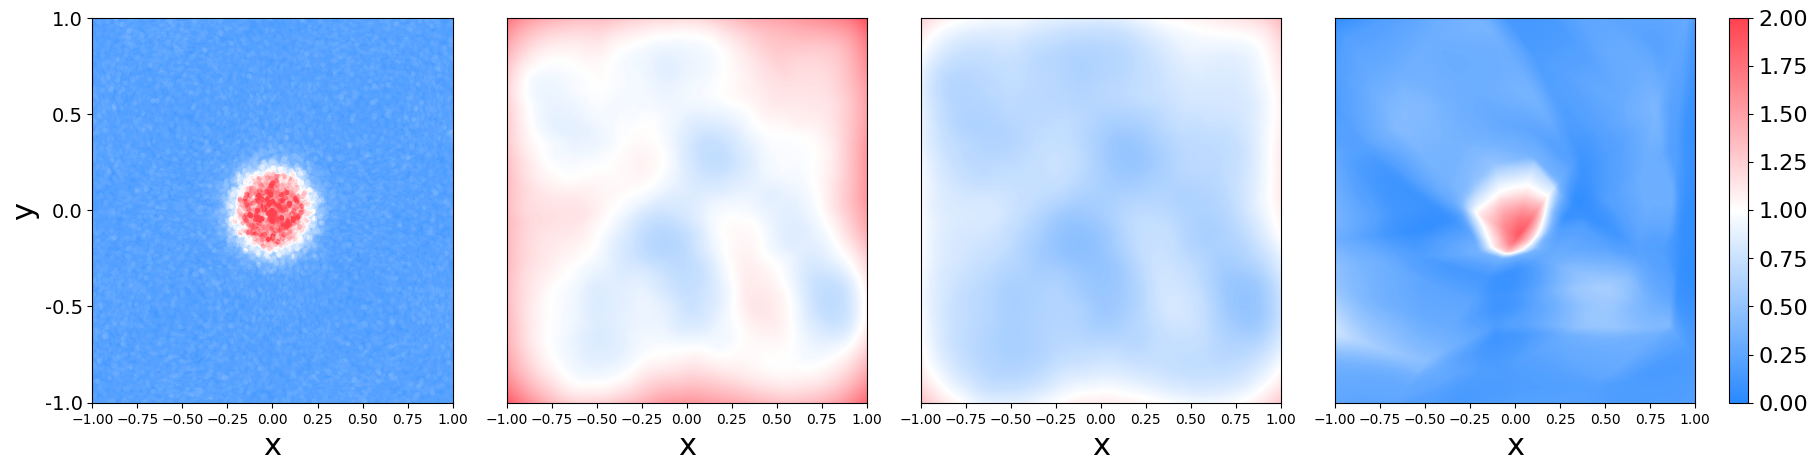

In [11]:
grid_noisy = X_test[id_test]
plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    y_tick_step=0.5,
    grid_size=500
)

# df1=cp_df_local_smooth
# df2=adap_df_local_smooth
# cp_df_local, #<--
# adap_df_local, #<--

In [12]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=50)

In [13]:
save_plot(
    plot_2D_comparison_with_coverage_error_compare,
    save_dir="Local_CP_2D",
    prefix="1disc"
)(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    y_tick_step=0.5,
    grid_size=500
)

<Figure size 640x480 with 0 Axes>

# Test across the alpha grid

In [14]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid_2d_ac, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas




cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    **quantile_net_config
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)




Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:14<04:12, 14.02s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:28<04:00, 14.16s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [00:42<03:46, 14.14s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [00:56<03:33, 14.26s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:11<03:22, 14.46s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [01:26<03:09, 14.55s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [01:40<02:53, 14.42s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [01:54<02:37, 14.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [02:09<02:23, 14.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [02:23<02:08, 14.29s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [02:37<01:54, 14.31s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [02:51<01:39, 14.29s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [03:06<01:25, 14.27s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [03:20<01:11, 14.33s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [03:35<00:57, 14.38s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [03:49<00:43, 14.43s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [04:03<00:28, 14.38s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [04:18<00:14, 14.42s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [04:32<00:00, 14.35s/it]


Uncal dev:0.18492475143145948
Cal dev:0.06698742038792088


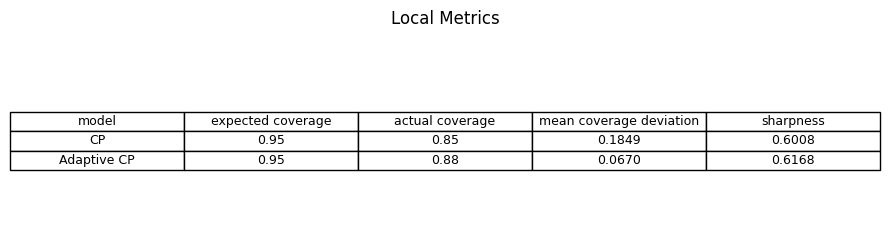

In [15]:
plot_metrics_table(None,None,None,None,cp_df_local,adap_df_local,"CP" ,"Adaptive CP", alpha_level=0.05, 
  main_title="Local Metrics"
)


In [16]:
# Global Metrics

# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas

cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    **quantile_net_config
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:14<04:18, 14.38s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:29<04:07, 14.56s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [00:43<03:53, 14.60s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [00:58<03:37, 14.52s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:12<03:24, 14.59s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [01:27<03:10, 14.67s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [01:42<02:55, 14.62s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [01:57<02:44, 14.95s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [02:13<02:30, 15.09s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [02:28<02:15, 15.05s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [02:43<02:01, 15.13s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [02:58<01:45, 15.11s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [03:12<01:29, 14.90s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [03:27<01:14, 14.82s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [03:42<00:59, 14.80s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [03:56<00:44, 14.74s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [04:11<00:29, 14.70s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [04:25<00:14, 14.59s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [04:40<00:00, 14.75s/it]


Uncal dev:0.03654761097970463
Cal dev:0.01669047222960563


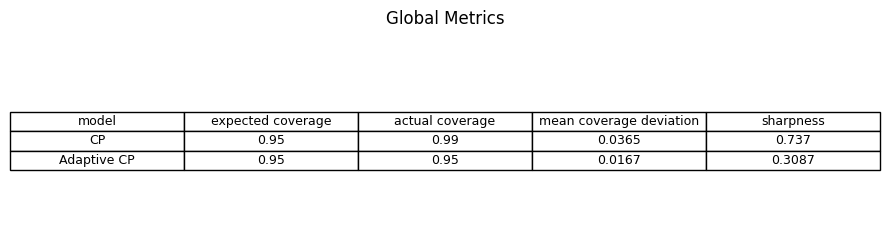

In [17]:
df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"

plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Global Metrics"
)

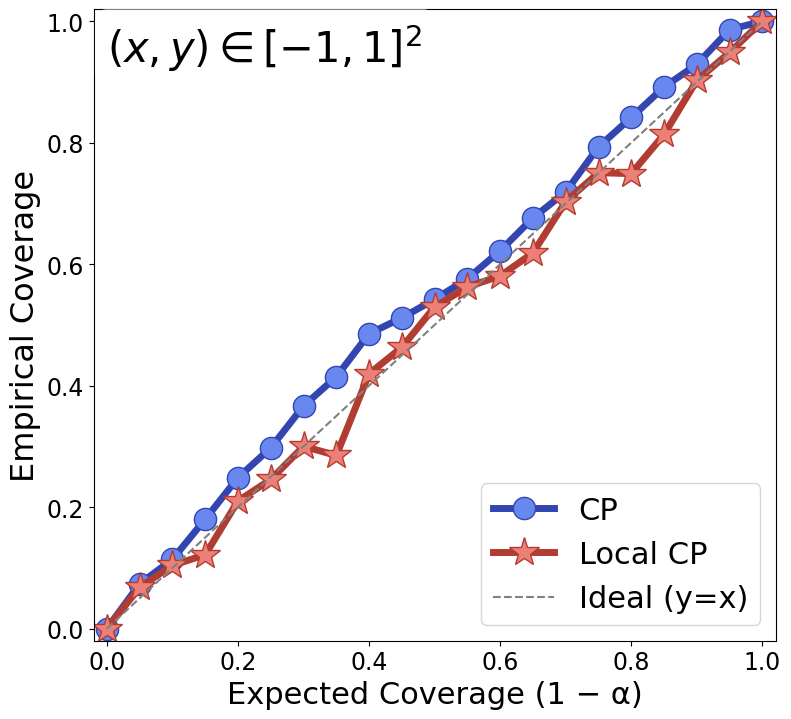

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7.8, 7.5),
    suptitle=None,
    model_title_size=28,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)
    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
             ms=16, lw=5, label=labels[0])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
             ms=22, lw=5, label=labels[1])
    
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # plt.text(
    #         0.02, 0.98, "Global",
    #         transform=plt.gca().transAxes,
    #         fontsize=28, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=30, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.xlabel("Expected Coverage (1 − α)", fontsize=22)
    plt.ylabel("Empirical Coverage", fontsize=23)
    # plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    # plt.yticks([])
    # plt.xticks([])
    plt.legend(loc="lower right", fontsize=22, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=17)
    return plt


pairs = ("Scenario A", cp_df_global,    adap_df_global)


plot_coverage_single(
    pairs,
    float_label=r"$(x,y) \in [-1, 1]^2$"
)
save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_A_global"
)(
    pairs,
    float_label=r"$(x,y) \in [-1, 1]^2$"
)



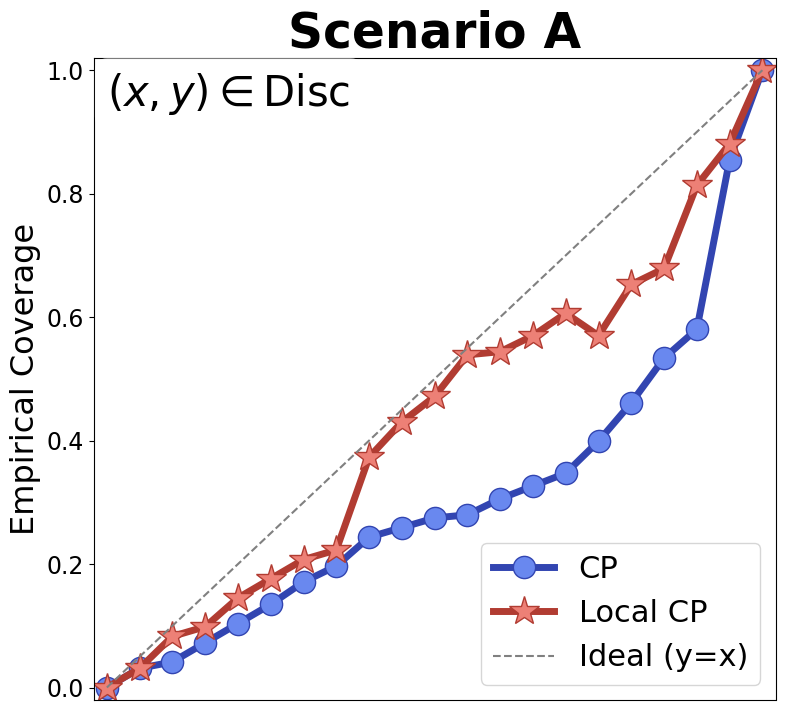

<Figure size 640x480 with 0 Axes>

In [19]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7.8, 7.5),
    suptitle=None,
    model_title_size=35,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)
    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
             ms=16, lw=5, label=labels[0])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
             ms=22, lw=5, label=labels[1])
    
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # plt.text(
    #         0.02, 0.98, "Local",
    #         transform=plt.gca().transAxes,
    #         fontsize=28, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=30, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    # plt.xlabel("Expected Coverage (1 − α)", fontsize=23)
    plt.ylabel("Empirical Coverage", fontsize=23)
    plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    plt.xticks([])
    plt.legend(loc="lower right", fontsize=22, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=17)
    return plt

pairs = ("Scenario A", cp_df_local,    adap_df_local)


plot_coverage_single(
    pairs,
    float_label=r"$(x, y) \in \mathrm{Disc}$"
)

save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_A_local"
)(
    pairs,
    float_label=r"$(x, y) \in \mathrm{Disc}$"
)

In [20]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=55)


In [21]:

save_plot(
    plot_2D_comparison_with_coverage_error_compare,
    save_dir="Local_CP_2D",
    prefix="1disc"
)(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    y_tick_step=0.5,
    grid_size=500
)

<Figure size 640x480 with 0 Axes>